In [447]:
from random import sample

import matplotlib.pyplot as plt     # Para graficar
import numpy as np                  # Para manejo de arreglos
import pandas as pd                 # Para manejo dee tablas
import statistics as st             # Para estadísticas (librería estándar)
import scipy.stats as sp            # Para estadísticas (librería científica)
import wfdb                         # Para manejo de bases de datos fisiológicas
import os                           # Para manejo de archivos e interacción con sistema operativo

from scipy.signal import find_peaks                         # Para encontrar picos en señales
from skimage.restoration import denoise_wavelet             # Para filtrado de señales
from scipy.fft import rfft, rfftfreq                        # Para transformada de Fourier
from keras.models import Sequential                         # Para creación de modelos de redes neuronales
from keras.layers import Dense                              # Para creación de capas densas
from keras.optimizers import SGD                            # Para optimización de modelos

In [448]:
import hashlib                    # Para verificación de integridad de archivos

mit_bih_db_path = './data/mitdb'

class RawDataWrapper:
    def __init__(self, record_name, data, headers, annotations):
        self.record_name = record_name
        self.data = data
        self.headers = headers
        self.annotations = annotations

class RawDataHandler:
    def __init__(self, db_path = 'mitdb'):
        self.db_path = db_path
        self.is_local_db = os.path.isdir(self.db_path)
        self.records_names = self.get_record_list()
    
    # Obtiene la lista de registros, si la base de datos es local lee el archivo RECORDS, si no descarga desde PhysioNet
    def get_record_list(self):
        if self.is_local_db:
            # Lee la lista de registros desde el archivo RECORDS
            with open(self.db_path + '/RECORDS') as f:
                records = f.readlines()
                records = [x.strip() for x in records]
            return records
        else:
            return wfdb.get_record_list(self.db_path, records='all')
    
    # Verifica que la base de datos local esté completa, requiere el archivo sha256sums
    def is_local_dataset_integrity_ok(self, sha256sums_file_path, ignore_extensions=['.xws']):
        if not os.path.isfile(sha256sums_file_path):
            print('Cannot verify integrity, sha256sums file not found')
            return False
        with open(sha256sums_file_path) as f:
            file_line = f.readlines()
            split_lines = [x.strip().split(" ") for x in file_line]
            for line in split_lines:
                file = self.db_path + '/' + line[1]
                if any(ext in file for ext in ignore_extensions):
                    continue
                if not os.path.isfile(file):
                    print('File ' + line[1] + ' not found in database')
                    return False
                # Verifica la suma sha256 del archivo
                with open(file, 'rb') as h:
                    file_hash = hashlib.sha256(h.read()).hexdigest()
                    if file_hash != line[0]:
                        print('File ' + line[1] + ' has an invalid hash')
                        return False
        return True

    def get_pn_dir(self):
        if self.is_local_db:
            return None
        else:
            return self.db_path
        
    def get_record_name_path(self, record_name):
        if self.is_local_db and (record_name in self.records_names):
            return self.db_path + '/' + record_name
        return record_name

    def get_data(self, name, start=0, end=None, channels=None):
        return wfdb.io.rdrecord(self.get_record_name_path(name), pn_dir=self.get_pn_dir(), sampfrom=start, sampto=end, channels=channels)
    
    # Obtiene los encabezados de un archivo de la base de datos
    def get_headers(self, name):
        return wfdb.io.rdheader(self.get_record_name_path(name), pn_dir=self.get_pn_dir())
    
    # Obtiene las anotaciones de un archivo de la base de datos
    def get_annotations(self, name):
        return wfdb.io.rdann(self.get_record_name_path(name), 'atr', pn_dir=self.get_pn_dir())
    
    def get(self, name):
        return RawDataWrapper(name, self.get_data(name), self.get_headers(name), self.get_annotations(name))
    
    # Obtiene todas las muestras de datos
    def get_all_data(self):
        data = []
        for record in self.records_names:
            data.append(self.get_data(record))
        return data
    
    # Obtiene todos los encabezados
    def get_all_annotations(self):
        annotations = []
        for record in self.records_names:
            annotations.append(self.get_annotations(record))
        return annotations
            
    def get_all_in_wrapper(self):
        data = []
        for record in self.records_names:
            data.append(self.get(record))
        return data

In [449]:
raw_data_manager = RawDataHandler(mit_bih_db_path)

sample_name = raw_data_manager.records_names[0]
# Verifica la integridad de la base de datos si es local
if raw_data_manager.is_local_db:
    if raw_data_manager.is_local_dataset_integrity_ok(mit_bih_db_path + '/SHA256SUMS.txt', ignore_extensions=['.xws', '.htm, .at_']):
        print('Local database integrity OK')
        sample = raw_data_manager.get_data(sample_name, 0, 3600, channels=[0])

Local database integrity OK


Nombre de la muestra: 100
Numero de señales muestreadas a 360/s: 3600


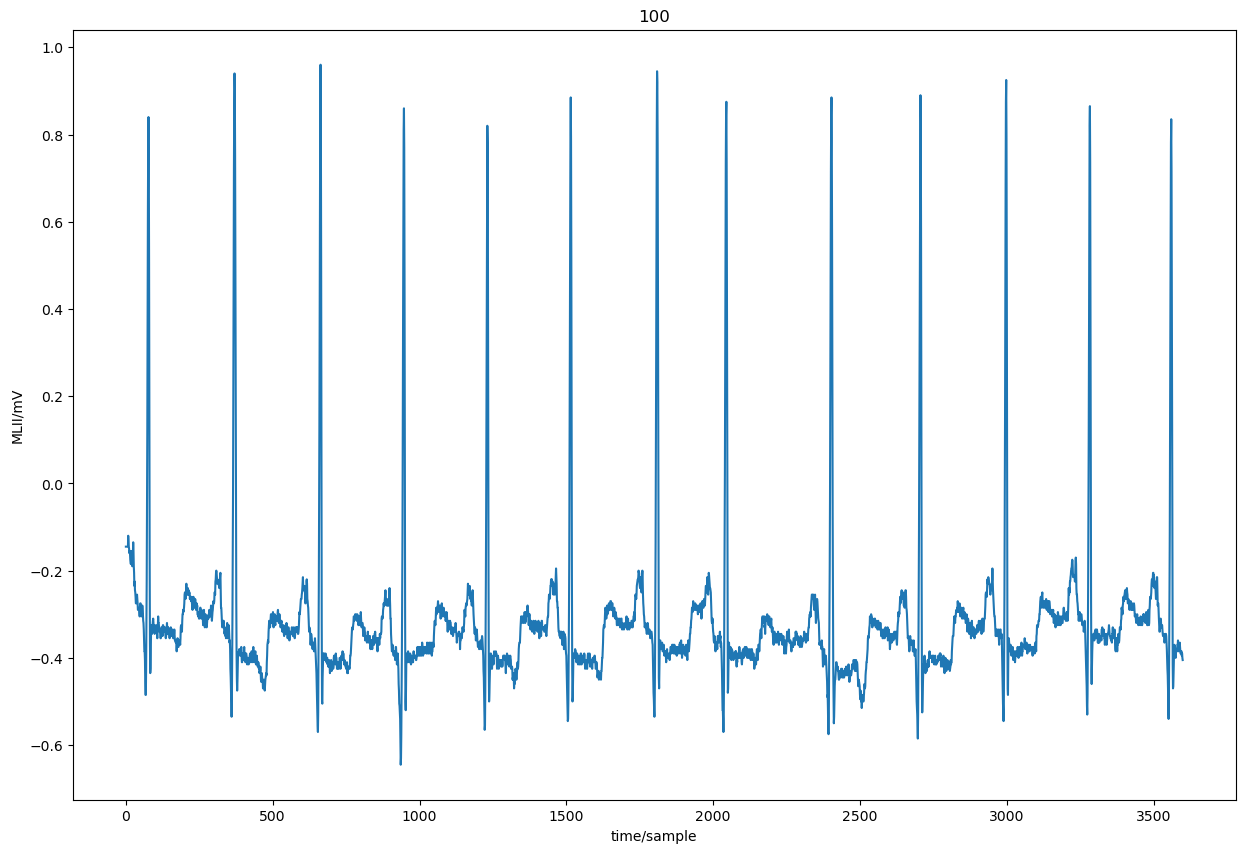

In [450]:
print(f'Nombre de la muestra: {sample.record_name}\nNumero de señales muestreadas a {sample.fs}/s: {sample.sig_len}')
wfdb.plot.plot_wfdb(record=sample, title=sample_name, figsize=(15, 10), time_units='samples')

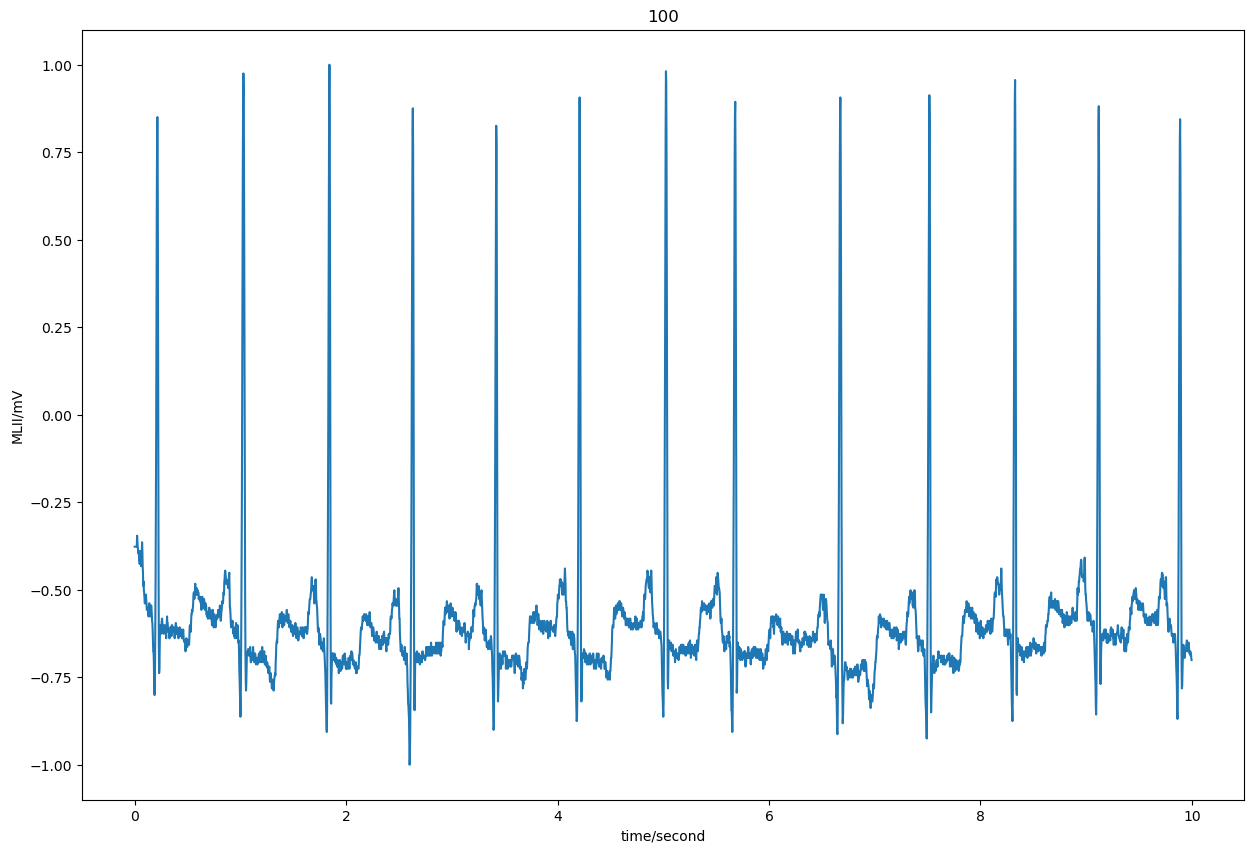

In [451]:
def normalize_signal(data, lb=0, ub=1):
    mid = ub - (ub - lb) / 2
    min_v = np.min(data)
    max_v = np.max(data)
    mid_v = max_v - (max_v - min_v) / 2
    coe = (ub - lb) / (max_v - min_v)
    return data * coe - (mid_v * coe) + mid

# Preprocesamiento de la señal
sample.p_signal = normalize_signal(sample.p_signal, lb=-1)
# Gráfica de la señal pre-procesada
wfdb.plot.plot_wfdb(record=sample, title=sample_name, figsize=(15, 10), time_units='seconds')

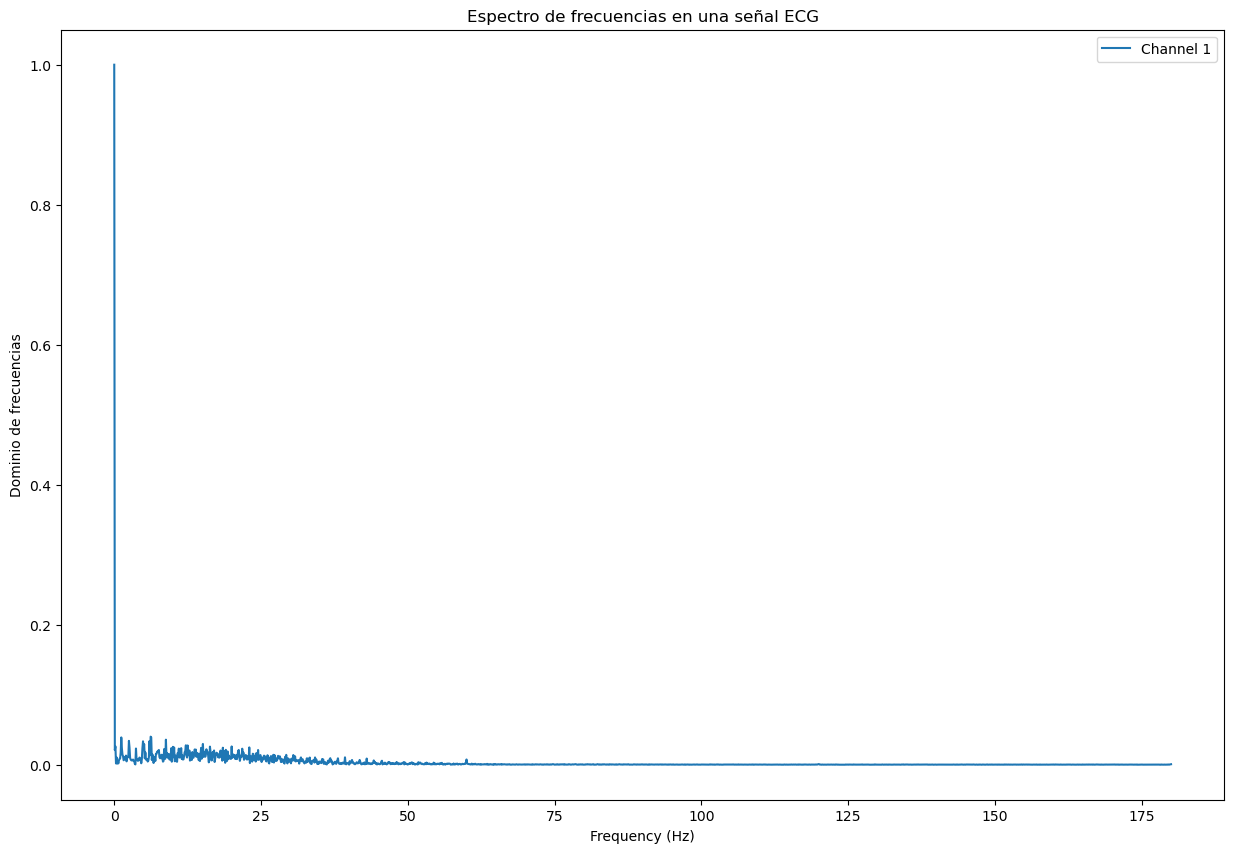

In [452]:
# Transformada de fourier
def fast_fourier_transform(signal, fs):
    y_ecg = rfft(signal)
    y_ecg = np.abs(y_ecg)
    y_ecg = y_ecg / np.ndarray.max(y_ecg)
    x_ecg = rfftfreq(np.size(signal), 1 / fs)
    return x_ecg, y_ecg

# Obtención de la gráfica
ch1_fft_x, ch1_fft_y = fast_fourier_transform(np.array(sample.p_signal[:, 0]), sample.fs)

plt.figure(figsize=(15, 10))
plt.plot(ch1_fft_x, ch1_fft_y, label='Channel 1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Dominio de frecuencias')
plt.title('Espectro de frecuencias en una señal ECG')
plt.legend()
plt.show()

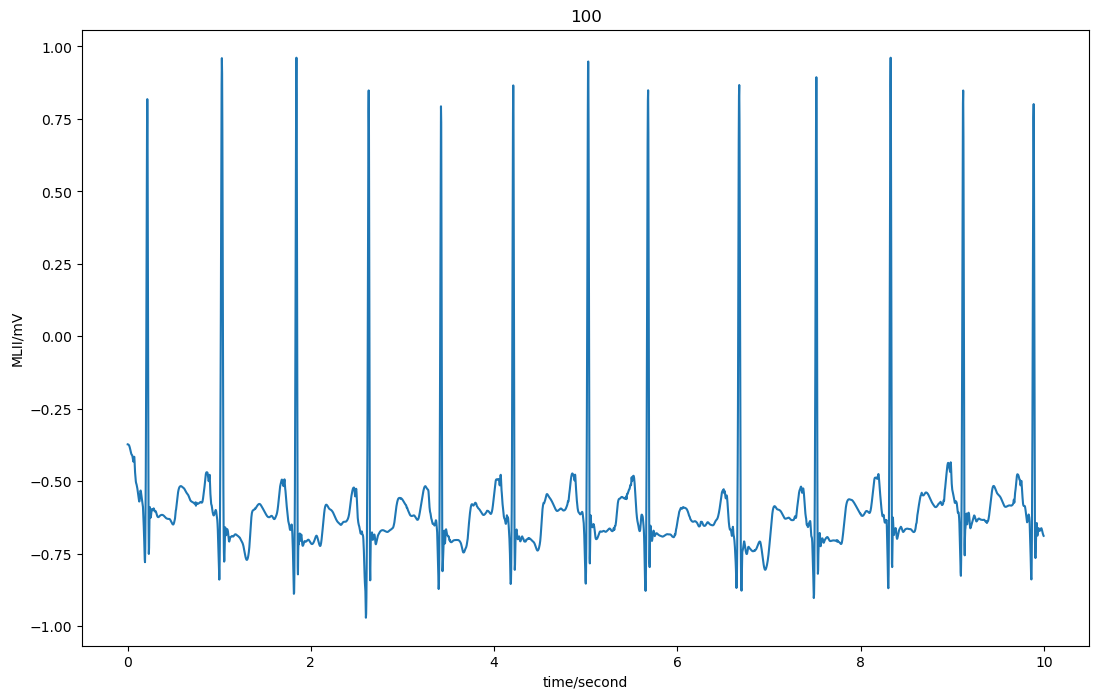

In [453]:
def wavelet_transform(signal):
    return denoise_wavelet(signal, 
                           method='VisuShrink', 
                           mode='soft', 
                           wavelet_levels=6, 
                           wavelet='sym8', 
                           rescale_sigma='True')

def denoise_signal(signal):
    denoised_ch1 = wavelet_transform(np.array(signal[:, 0]))
    signal[:, 0] = denoised_ch1

def get_time_vector(signal, freq_sampling):
    return np.linspace(0, np.size(signal), np.size(signal)) * (1 / freq_sampling)

noised_signal = np.copy(sample.p_signal)
denoise_signal(sample.p_signal)
time_vector = get_time_vector(sample.p_signal[:, 0], sample.fs)
# Gráfica de la señal preprocesada
wfdb.plot.plot_wfdb(record=sample, title=sample_name, figsize=(13, 8), time_units='seconds')

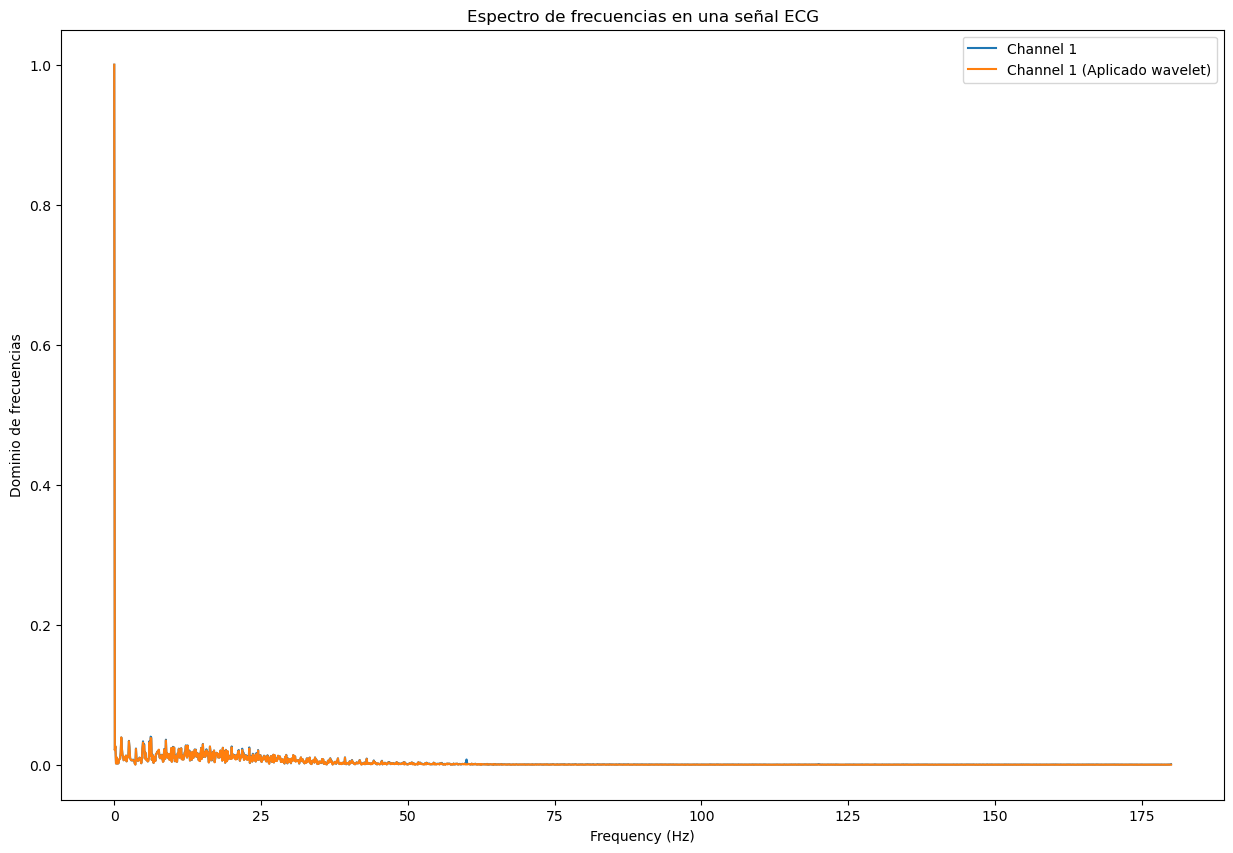

In [454]:
_, ch1_denoise_fft_y = fast_fourier_transform(sample.p_signal[:, 0], sample.fs)
plt.figure(figsize=(15, 10))
plt.plot(ch1_fft_x, ch1_fft_y, label='Channel 1')
plt.plot(ch1_fft_x, ch1_denoise_fft_y, label='Channel 1 (Aplicado wavelet)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Dominio de frecuencias')
plt.title('Espectro de frecuencias en una señal ECG')
plt.legend()
plt.show()

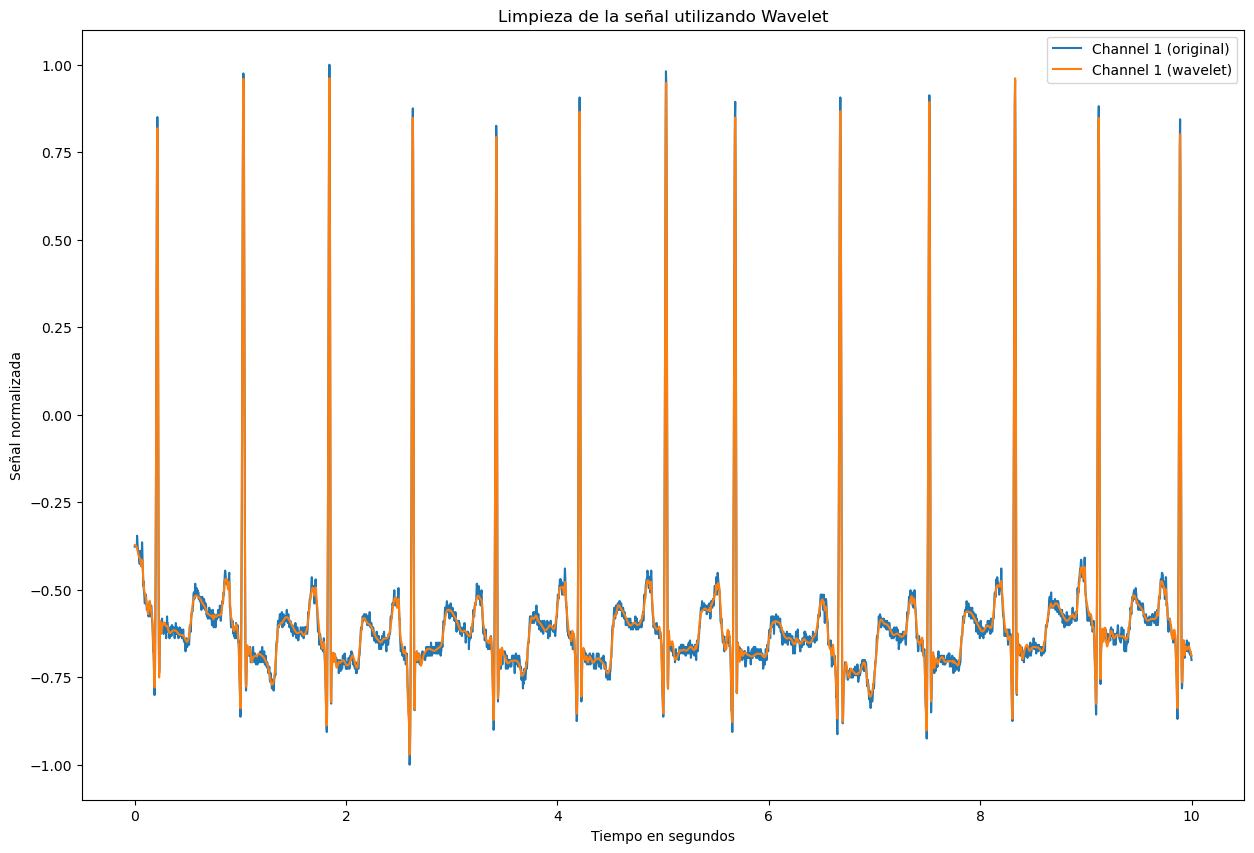

In [455]:
plt.figure(figsize=(15, 10))
plt.plot(time_vector, noised_signal[:, 0], label='Channel 1 (original)')
plt.plot(time_vector, sample.p_signal[:, 0], label='Channel 1 (wavelet)')
plt.xlabel('Tiempo en segundos')
plt.ylabel('Señal normalizada')
plt.title('Limpieza de la señal utilizando Wavelet')
plt.legend()
plt.show()

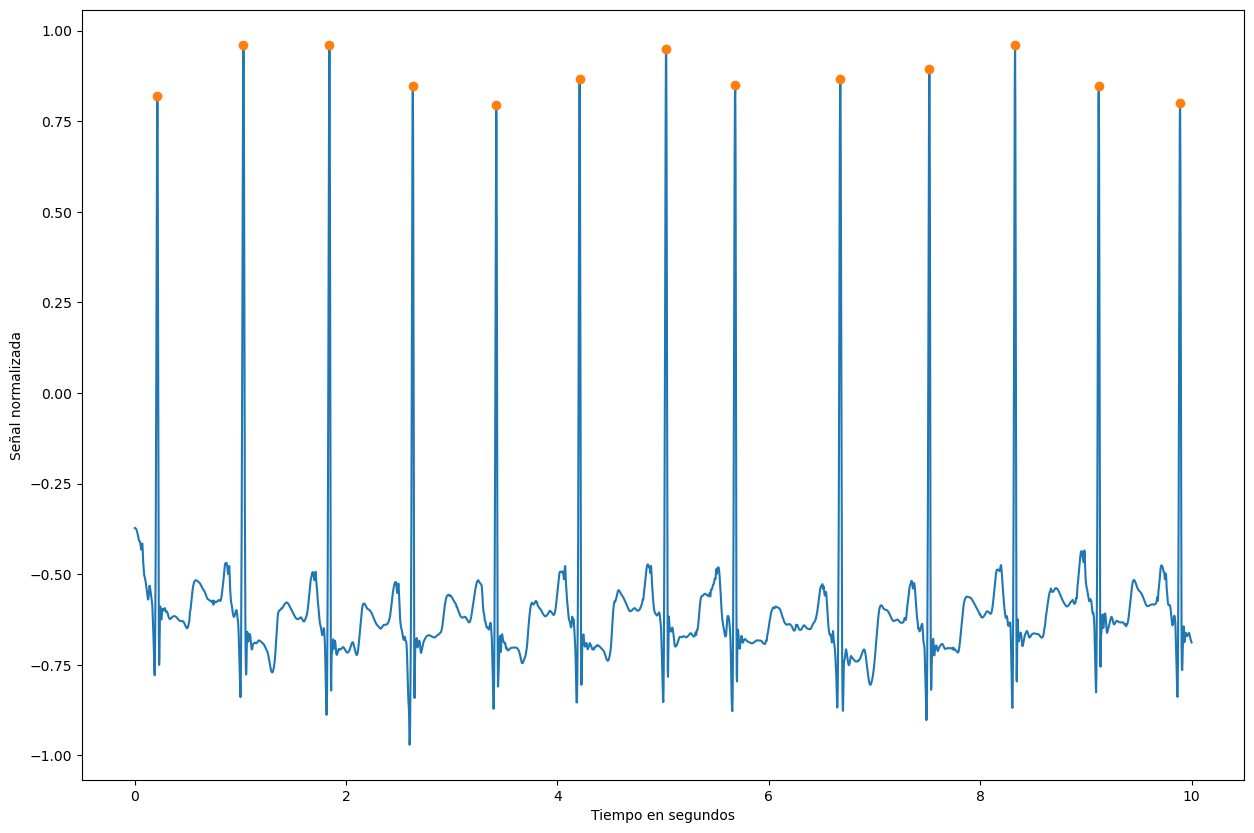

In [456]:
# Obtención de los picos en la señal (onda R)
def umbral_peaks(signal):
    absolute_ch= np.abs(signal)
    umbral_y_ch = np.mean(absolute_ch)
    # Los picos son encontrados en donde el valor de la señal supera a la media 
    peaks_ch1, _ = find_peaks(signal, height=umbral_y_ch)
    return peaks_ch1

ch1_peaks= umbral_peaks(sample.p_signal[:, 0])

plt.figure(figsize=(15, 10))
plt.plot(time_vector, sample.p_signal[:, 0])
plt.plot(time_vector[ch1_peaks], sample.p_signal[:, 0][ch1_peaks], "o")
plt.xlabel('Tiempo en segundos')
plt.ylabel('Señal normalizada')
plt.show()

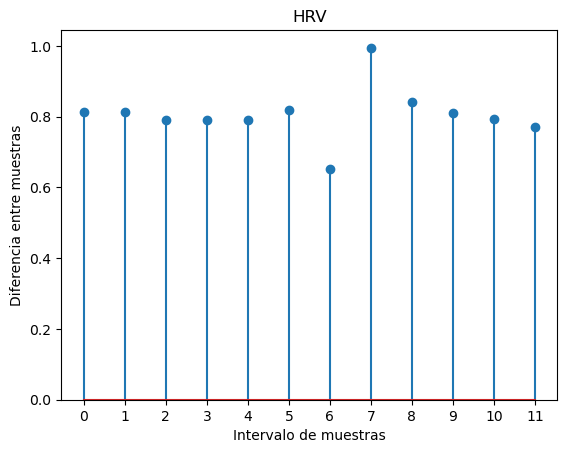

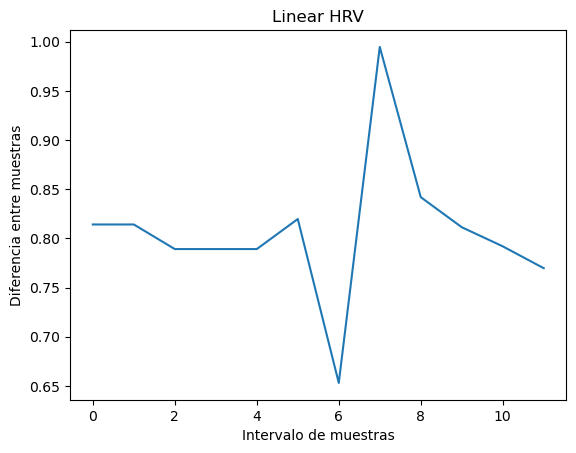

In [457]:
def heart_rate_variability(peaks):
    # Realiza la diferencia entre cada una de las muestras, el resultado lo almacena en otro arreglo
    hrv = np.diff(peaks)
    return hrv

hrv_ch1 = heart_rate_variability(time_vector[ch1_peaks])
fig, axes = plt.subplots()
axes.stem(np.arange(0, np.size(hrv_ch1)), hrv_ch1)
axes.set_ylim(0)

plt.title("HRV")
plt.xlabel("Intervalo de muestras")
plt.ylabel("Diferencia entre muestras")
plt.xticks(np.arange(0, np.size(hrv_ch1)))
plt.show()
plt.title("Linear HRV")
plt.xlabel("Intervalo de muestras")
plt.ylabel("Diferencia entre muestras")
plt.plot(np.arange(0, np.size(hrv_ch1)), hrv_ch1)
plt.show()

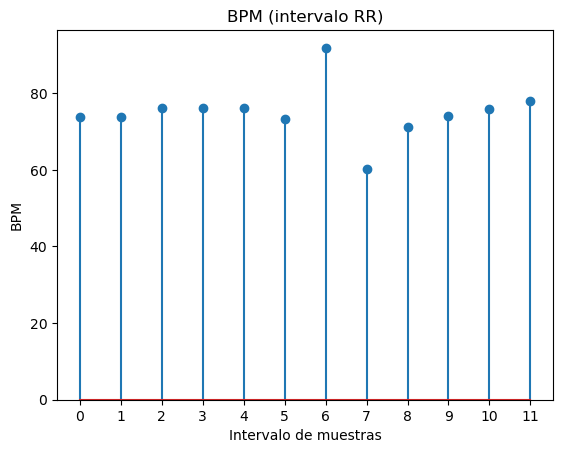

In [458]:
def get_bpm(rr_interval):
    return (1 / rr_interval) * 60

bpm_ch1 = get_bpm(hrv_ch1)
_, axes = plt.subplots()
axes.stem(np.arange(0, np.size(bpm_ch1)), bpm_ch1)
axes.set_ylim(0)
plt.title("BPM (intervalo RR)")
plt.xlabel("Intervalo de muestras")
plt.ylabel("BPM")
plt.xticks(np.arange(0, np.size(bpm_ch1)))
plt.show()

In [459]:
def rmssd(hrv):
    suma = 0
    # Realiza la diferencia entre cada una de las muestras, el resultado lo almacena en otro arreglo 
    resta_rr = np.diff(hrv)
    if np.size(resta_rr) == 0:
        return 0
    # Eleva al cuadrado las diferencias y las suma
    squared_numbers = [number ** 2 for number in resta_rr]
    for num in squared_numbers:
        suma += num
    normalize = suma / np.size(resta_rr)
    rmssd_value = np.sqrt(normalize)
    return rmssd_value*1000
        
rmssd_ch1 = rmssd(hrv_ch1)
print(f'RMSSD: {rmssd_ch1}')

RMSSD: 124.7959415108325


In [460]:
def pnnx(hrv, x):
    # Valor absoluto de las diferencias entre intervalo RR
    resta_rr = np.abs(np.diff(hrv))
    if np.size(resta_rr) == 0:
        return 0, 0
    filtering_condition = resta_rr > (x / 1000)
    # Obtiene el conteo de todos los elementos cuya diferencia es mayor a x
    cumulative_sum = np.size(resta_rr[filtering_condition])
    return (cumulative_sum / np.size(resta_rr)) * 100, cumulative_sum

pnn50, cumulative_sum = pnnx(hrv_ch1, 50)
print(f'PNN50: {pnn50}%\tTotal: {cumulative_sum}')

PNN50: 27.27272727272727%	Total: 3


In [461]:
def get_shannon(signal):
    y = np.power(signal, 2)
    y1 = np.sum(y)
    pe = y / y1
    se = -np.sum(pe * np.log(np.power(pe, 2)))
    return se

def get_logenergy(signal):
    y = np.power(signal, 2)
    y1 = np.sum(y)
    pe = y / y1
    lee = np.sum(pe * np.log(pe))
    return lee

def statistics(signal):
    min_value = np.min(signal)
    max_value = np.max(signal)
    mean_value = np.mean(signal)
    median_value = np.median(signal)
    sum_value = np.sum(signal)
    std_value = st.stdev(signal)
    var_value = st.variance(signal)
    skw_value = sp.skew(signal) 
    kurtosis_value = sp.kurtosis(signal)
    shannon_entropy = get_shannon(signal)
    energy_entropy = get_logenergy(signal)
    return min_value, max_value, mean_value, median_value, sum_value, std_value, var_value, skw_value, kurtosis_value, shannon_entropy, energy_entropy

In [462]:
# Tabla que contiene los símbolos de interés y su descripción
symbols_table = pd.DataFrame([
    ['N', 'Normal Sinus Rhythm'],
    ['·', 'Normal Sinus Rhythm'],
    ['L', 'Left Branch Block Beat'],
    # ['R', 'Right Branch Block Beat'],
    # ['A', 'Atrial Premature Contraction'],
    # ['a', 'Aberrated Atrial Premature Contraction'],
    # ['J', 'Nodal (junctional) Premature Contraction'],
    # ['S', 'Supraventricular Premature or Ectopic Beat'],
    ['V', 'Premature Ventricular Contraction'],
    # ['F', 'Fusion of ventricular and normal beat'],
    # ['[', 'Start of Ventricular Flutter'],
    # ['!', 'Start of Ventricular Flutter'],
    # [']', 'Start of Ventricular Flutter'],
    # ['e', 'Atrial Escape Beat'],
    # ['j', 'Nodal (junctional) Escape Beat'],
    # ['E', 'Ventricular Escape Beat'],
    # ['/', 'Paced Beat'],
    # ['f', 'Fusion of paced and normal beat'],
    # ['n', 'Supraventricular Escape Beat'],
    # ['Q', 'Unclassifiable Beat'],
    # ['?', 'Beat not classified during learning'],
    # ['|', 'Isolated QRS-like artifact']
], columns=['symbol', 'Name'])

# Tabla que contiene las clases de interés
subtype_table = pd.DataFrame([
    # ['(AB\x00', 'Atrial bigeminy'],
    ['(AFIB\x00', 'Atrial fibrillation'],
    # ['(AFL\x00', 'Atrial flutter'],
    # ['(B\x00', 'Ventricular bigeminy'],
    # ['(BII\x00', '2° heart block'],
    # ['(IVR\x00', 'Idioventricular rhythm'],
    # ['(N\x00', 'Normal sinus rhythm'],
    # ['(NOD\x00', 'Nodal (A-V junctional) rhythm'],
    # ['(P\x00', 'Paced rhythm'],
    # ['(PREX\x00', 'Pre-excitation (WPW)'],
    # ['(SBR\x00', 'Sinus bradycardia'],
    # ['(SVTA\x00', 'Supraventricular tachyarrhythmia'],
    # ['(T\x00', 'Ventricular trigeminy'],
    # ['(VFL\x00', 'Ventricular flutter'],
    # ['(VT\x00', 'Ventricular tachycardia']
], columns=['string', 'Name'])
    
# Construye una tabla de intervalos con sus respectivas clases y símbolos
def get_annotations_table(data_container):
    annotation_data = {
        'name': [],
        'symbol': [],
        'aux': [],
        'start_sample': [],
        'length': []
    }
    for container in data_container:
        size = np.size(container.annotations.symbol)
        for i in range(0, size - 1):
            symbol = container.annotations.symbol[i]
            annotation_data['name'].append(container.annotations.record_name)
            annotation_data['symbol'].append(symbol)
            annotation_data['aux'].append(container.annotations.aux_note[i])
            annotation_data['start_sample'].append(container.annotations.sample[i])
            annotation_data['length'].append(container.annotations.sample[i + 1] - container.annotations.sample[i])
        symbol = container.annotations.symbol[-1]
        annotation_data['name'].append(container.annotations.record_name)
        annotation_data['symbol'].append(symbol)
        annotation_data['aux'].append(container.annotations.aux_note[-1])
        annotation_data['start_sample'].append(container.annotations.sample[-1])
        annotation_data['length'].append(np.size(container.data.p_signal[:,0]) - container.annotations.sample[-1])
    return pd.DataFrame(annotation_data)

data_wrappers = raw_data_manager.get_all_in_wrapper()
ann = get_annotations_table(data_wrappers)
ann

,name,symbol,aux,start_sample,length
0,100,+,(N ,18,59
1,100,N,,77,293
2,100,N,,370,292
3,100,N,,662,284
4,100,N,,946,285
...,...,...,...,...,...
112642,234,N,,648797,243
112643,234,N,,649040,252
112644,234,N,,649292,244
112645,234,N,,649536,236


In [463]:
class ChunkManager:
    def __init__(self, table, column='symbol'):
        self.table = table
        self.selected_column = column
        self.chunks = {
            'name': [],
            'symbol': [],
            'start_sample': [],
            'length': []
        }
        self.current_symbol = table[self.selected_column].iat[0]
        self.current_name = table.name.iat[0]
        self.start = 0
        self.length = 0
        index = self.table.columns.get_loc(self.selected_column) + 1
        if self.selected_column == 'aux':
            self.get_aux_chunks(index)
        elif self.selected_column == 'symbol':
            self.get_symbol_chunks(index)
    
    def get_symbol_chunks(self, index):
        for row in self.table.itertuples():
            self.read_row(row, index)
            self.verify_length(row, index)
            self.length += row.length
    
    def get_aux_chunks(self, index):
        for row in self.table.itertuples():
            if row[index] != '':
                self.read_row(row, index)
            self.verify_length(row, index)
            self.length += row.length
            
    def read_row(self, row, index):
        if row[index] != self.current_symbol or self.current_name != row.name:
            self.submit_chunk()
            self.set_aux(row[index], row.name, row.start_sample)
    
    def verify_length(self, row, index):
        if self.length > 3600:
            self.submit_chunk()
            self.set_aux(name=row.name, start=row.start_sample)
        
    def submit_chunk(self):
        self.chunks['name'].append(self.current_name)
        self.chunks['symbol'].append(self.current_symbol)
        self.chunks['start_sample'].append(self.start)
        self.chunks['length'].append(self.length)
        
    def set_aux(self, symbol=None, name='', start=0, length = 0):
        if symbol is not None:
            self.current_symbol = symbol
        self.current_name = name
        self.start = start
        self.length = length

In [464]:
# Obtiene todas las clases de interés
filtered_types = ann[ann['symbol'].isin(symbols_table['symbol'])]
symbol_chunk_manager = ChunkManager(filtered_types)
filtered_types

,name,symbol,aux,start_sample,length
1,100,N,,77,293
2,100,N,,370,292
3,100,N,,662,284
4,100,N,,946,285
5,100,N,,1231,284
...,...,...,...,...,...
112642,234,N,,648797,243
112643,234,N,,649040,252
112644,234,N,,649292,244
112645,234,N,,649536,236


In [465]:
symbol_chunks_table = pd.DataFrame(symbol_chunk_manager.chunks)
symbol_chunks_table

,name,symbol,start_sample,length
0,100,N,0,3735
1,100,N,4170,3783
2,100,N,7953,3828
3,100,N,11781,3826
4,100,N,15607,3781
...,...,...,...,...
16780,234,N,630711,3741
16781,234,N,634452,3632
16782,234,N,638084,3683
16783,234,N,641767,3643


In [466]:
filtered_aux = ann[ann['aux'].isin(subtype_table['string'])]
records_with_afib = filtered_aux['name'].unique()
whole_with_afib = ann[ann['name'].isin(records_with_afib)]
aux_chunk_manager = ChunkManager(whole_with_afib, column='aux')
whole_with_afib

,name,symbol,aux,start_sample,length
51016,201,+,(AFIB ,60,99
51017,201,N,,159,256
51018,201,N,,415,271
51019,201,N,,686,219
51020,201,N,,905,284
...,...,...,...,...,...
95649,222,N,,648985,172
95650,222,N,,649157,160
95651,222,N,,649317,283
95652,222,N,,649600,259


In [467]:
aux_chunks_table = pd.DataFrame(aux_chunk_manager.chunks)
aux_chunks_table

,name,symbol,start_sample,length
0,201,(AFIB ,0,3738
1,201,(AFIB ,3798,3816
2,201,(AFIB ,7614,3686
3,201,(AFIB ,11300,3714
4,201,(AFIB ,15014,3667
...,...,...,...,...
1373,222,(AFL,628425,3800
1374,222,(AFL,632225,3611
1375,222,(AFL,635836,3823
1376,222,(AFL,639659,3709


In [468]:
normal_chunks = symbol_chunks_table[symbol_chunks_table['symbol'].isin(['N'])].sort_values(by='length', ascending=False)
normal_chunks

,name,symbol,start_sample,length
12239,219,N,294487,4116
4819,123,N,70,4084
4845,123,N,99686,4082
4884,123,N,244408,4077
4846,123,N,103768,4073
...,...,...,...,...
7701,203,N,414945,71
8014,205,N,333687,67
12301,219,N,500976,61
5255,200,N,116262,61


In [469]:
lbbb_chunks = symbol_chunks_table[symbol_chunks_table['symbol'].isin(['L'])].sort_values(by='length', ascending=False)
lbbb_chunks

,name,symbol,start_sample,length
8284,207,L,544865,3939
8274,207,L,505842,3932
8282,207,L,537031,3918
8283,207,L,540949,3916
8213,207,L,272038,3910
...,...,...,...,...
11122,214,L,51472,142
11201,214,L,133984,142
8152,207,L,48019,114
11098,214,L,28035,78


In [470]:
pvc_chunks = symbol_chunks_table[symbol_chunks_table['symbol'].isin(['V'])].sort_values(by='length', ascending=False)
pvc_chunks

,name,symbol,start_sample,length
4995,124,V,219980,4093
8127,207,V,5648,4063
8157,207,V,70665,4026
8156,207,V,64967,3926
4994,124,V,115412,3903
...,...,...,...,...
9170,208,V,323484,64
1820,108,V,393056,64
1887,108,V,619235,64
7599,203,V,326696,34


In [471]:
afib_chunks = aux_chunks_table[aux_chunks_table['symbol'].isin(subtype_table['string'])].sort_values(by='length', ascending=False)
afib_chunks

,name,symbol,start_sample,length
963,221,(AFIB ,70559,4051
520,203,(AFIB ,470798,4003
895,219,(AFIB ,476585,3998
1060,221,(AFIB ,388731,3990
402,203,(AFIB ,101119,3986
...,...,...,...,...
1234,222,(AFIB ,312335,310
405,203,(AFIB ,109079,214
340,202,(AFIB ,549680,113
1016,221,(AFIB ,253224,83


In [472]:
# Filtrado de todas las tablas donde solo se contengan los elementos con length mayor a 3000
normal_chunks = normal_chunks[normal_chunks['length'] > 3000]
lbbb_chunks = lbbb_chunks[lbbb_chunks['length'] > 3000]
pvc_chunks = pvc_chunks[pvc_chunks['length'] > 3000]
afib_chunks = afib_chunks[afib_chunks['length'] > 3000]

In [473]:
# Separaciòn de cada tabla en 3 partes: 60% para entrenamiento, 20% para validación y 20% para prueba
def split_chunks(table):
    train, validate, test = np.split(table.sample(frac=1), [int(.6*len(table)), int(.8*len(table))])
    return train, validate, test

normal_train, normal_validate, normal_test = split_chunks(normal_chunks)
lbbb_train, lbbb_validate, lbbb_test = split_chunks(lbbb_chunks)
pvc_train, pvc_validate, pvc_test = split_chunks(pvc_chunks)
afib_train, afib_validate, afib_test = split_chunks(afib_chunks)

D:\Programs\anaconda3\envs\ecg\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [474]:
# Obtiene los datos de la base de datos
def get_records_symbol(table):
    records = []
    for row in table.itertuples():
        records.append(raw_data_manager.get_data(row.name, row.start_sample, row.start_sample + row.length, channels=[0]))
    return records

# Obtiene los registros de entrenamiento
normal_records_train = get_records_symbol(normal_train)
lbbb_records_train = get_records_symbol(lbbb_train)
pvc_records_train = get_records_symbol(pvc_train)
afib_records_train = get_records_symbol(afib_train)

In [475]:
# Obtiene los registros de validación
normal_records_validate = get_records_symbol(normal_validate)
lbbb_records_validate = get_records_symbol(lbbb_validate)
pvc_records_validate = get_records_symbol(pvc_validate)
afib_records_validate = get_records_symbol(afib_validate)

# Obtiene los registros de prueba
normal_records_test = get_records_symbol(normal_test)
lbbb_records_test = get_records_symbol(lbbb_test)
pvc_records_test = get_records_symbol(pvc_test)
afib_records_test = get_records_symbol(afib_test)

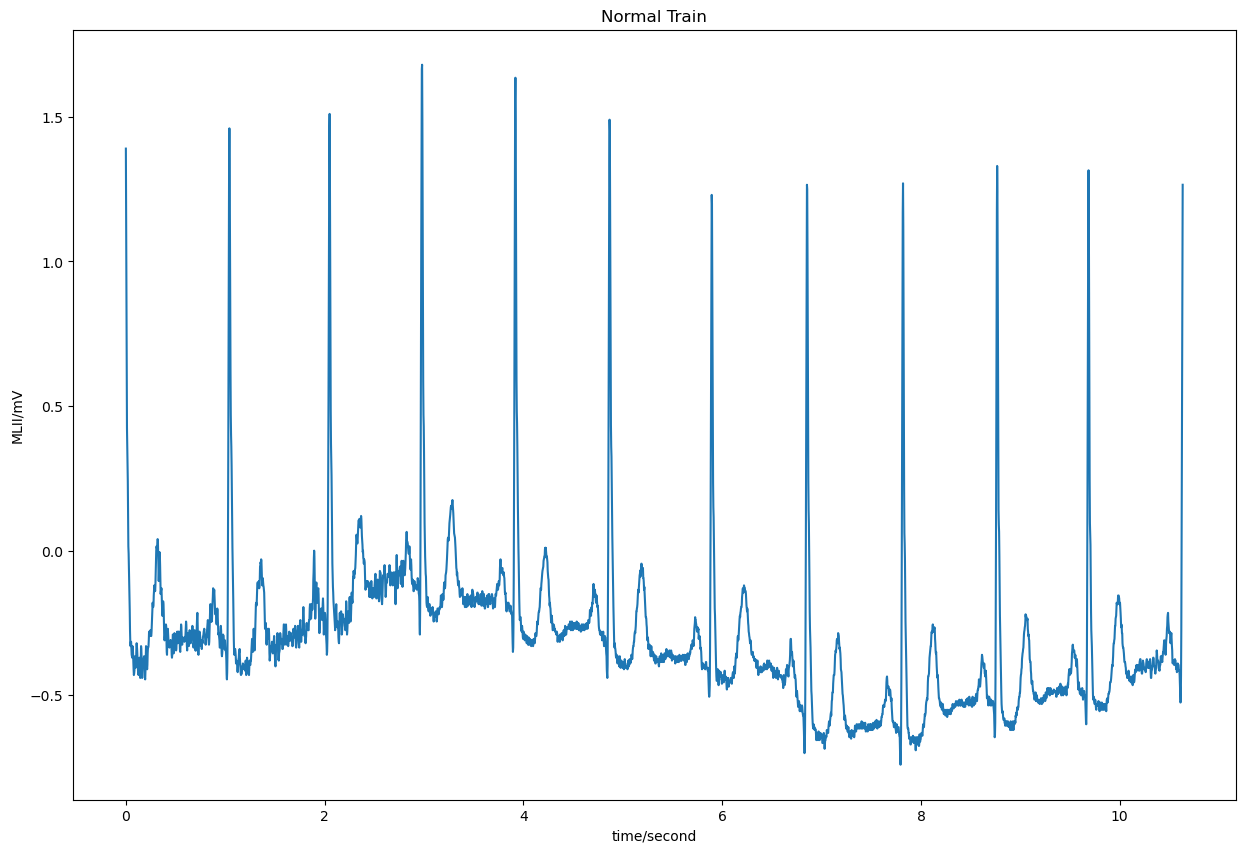

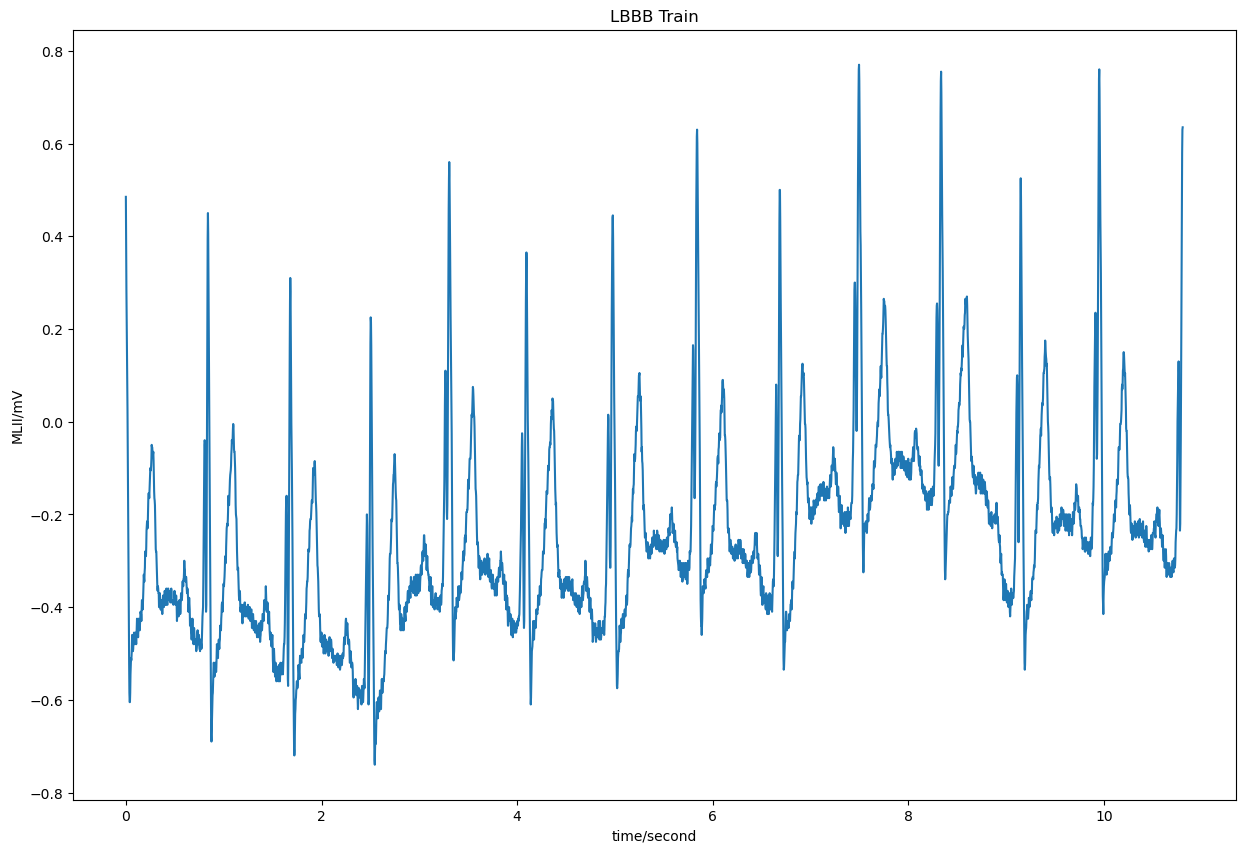

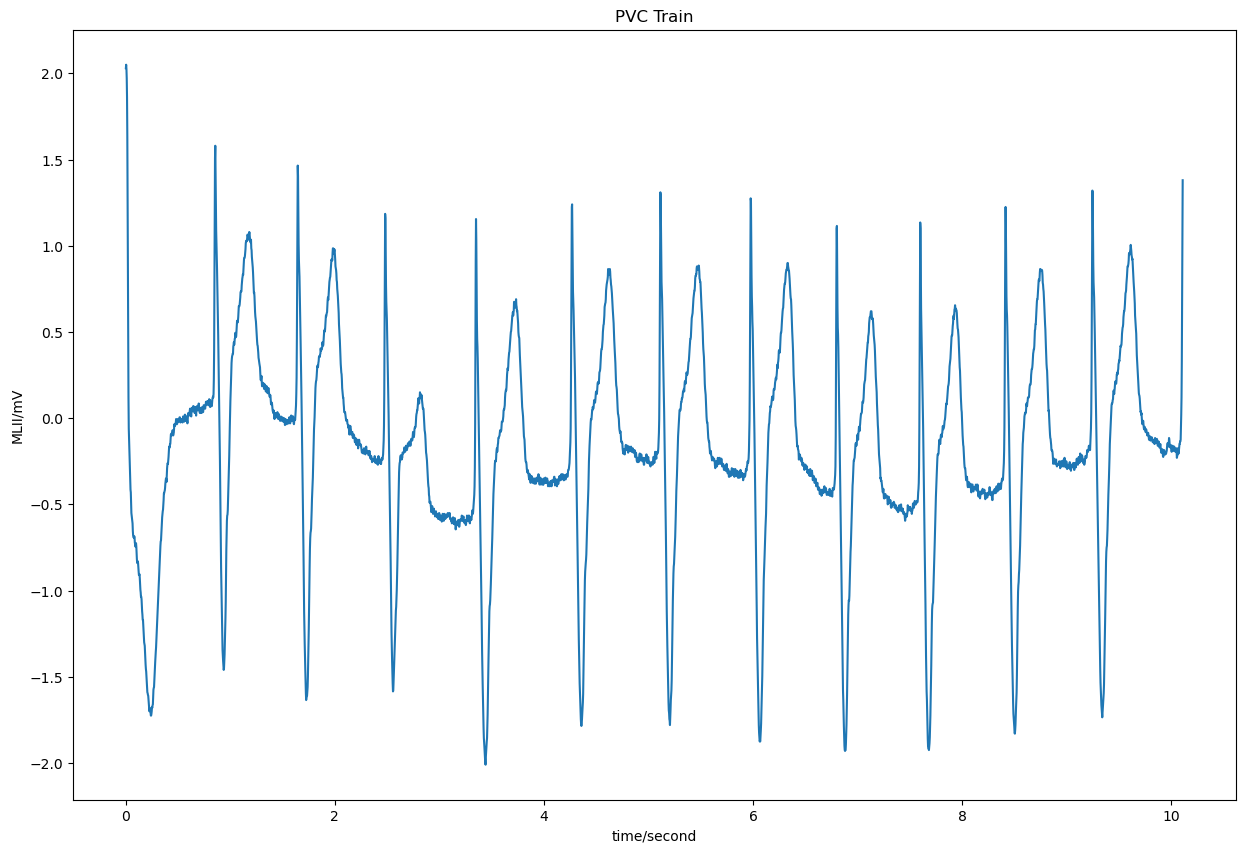

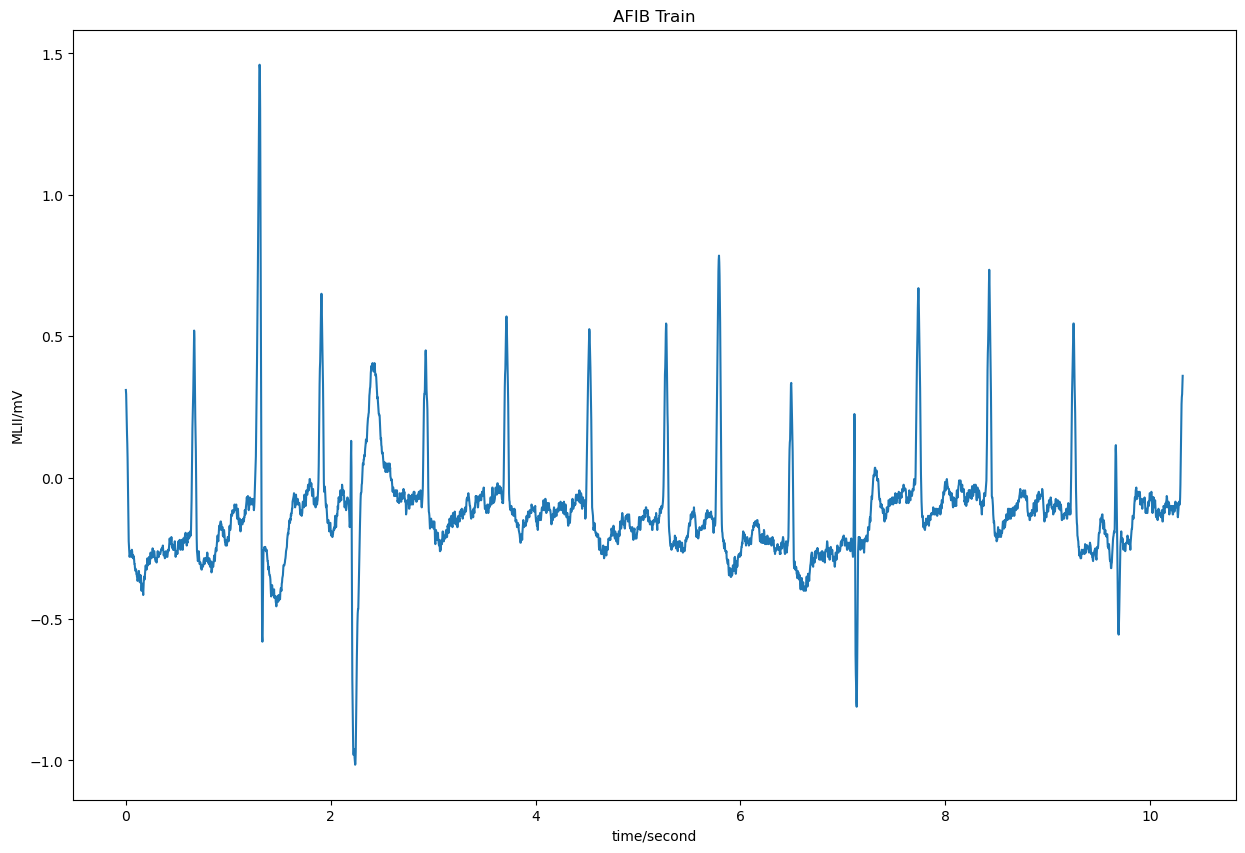

In [476]:
wfdb.plot_wfdb(record=normal_records_train[0], title='Normal Train', figsize=(15, 10), time_units='seconds')
wfdb.plot_wfdb(record=lbbb_records_train[0], title='LBBB Train', figsize=(15, 10), time_units='seconds')
wfdb.plot_wfdb(record=pvc_records_train[0], title='PVC Train', figsize=(15, 10), time_units='seconds')
wfdb.plot_wfdb(record=afib_records_train[0], title='AFIB Train', figsize=(15, 10), time_units='seconds')

In [477]:
class FeatureExtractor:
    def __init__(self, data, label=None):
        self.data_containers = data
        self.label = label
        self.features_table = pd.DataFrame(columns = [
            "label",
            'min', 
            'max', 
            'mean', 
            'median', 
            'sum', 
            'std', 
            'var',
            'skew',
            'kurtosis',
            'shannon ent',
            'log energy',
            'pnn25',
            'nn25',
            'pnn50',
            'nn50',
            'pnn75',
            'nn75',
            'rmssd'
        ])
    
    def start_characterization(self):
        self.normalize_signals()
        self.denoise_signals()
        self.extract_features()
        return self.features_table
    
    def extract_features(self):
        rows = []
        for item in self.data_containers:
            for i in range(np.size(item.p_signal, 1)):
                min_value, max_value, mean_value, median_value, sum_value, std_value, var_value, skw_value, kurtosis_value, shannon_entropy, energy_entropy = statistics(item.p_signal[:, i])
                time = get_time_vector(item.p_signal[:, i], item.fs)
                peaks = umbral_peaks(item.p_signal[:, i])
                hrv = heart_rate_variability(time[peaks])
                rmssd_value = rmssd(hrv)
                pnn25, nn25 = pnnx(hrv, 25)
                pnn50, nn50 = pnnx(hrv, 50)
                pnn75, nn75 = pnnx(hrv, 75)
                rows.append({
                    "label": self.label,
                    "min": min_value, 
                    "max": max_value, 
                    "mean": mean_value, 
                    "median": median_value, 
                    "sum": sum_value, 
                    "std": std_value, 
                    "var": var_value,
                    "skew": skw_value,
                    "kurtosis": kurtosis_value,
                    "shannon ent": shannon_entropy,
                    "log energy": energy_entropy,
                    "pnn25": pnn25,
                    "nn25": nn25,
                    "pnn50": pnn50,
                    "nn50": nn50,
                    "pnn75": pnn75,
                    "nn75": nn75,
                    "rmssd": rmssd_value
                })
        self.features_table = pd.concat([self.features_table, pd.DataFrame(rows)], ignore_index=True)
    
    def normalize_signals(self):
        for data in self.data_containers:
            data.p_signal = normalize_signal(data.p_signal, lb=-1)
    
    def denoise_signals(self):
        for data in self.data_containers:
            denoise_signal(data.p_signal)

In [478]:
# Instancia de la clase FeatureExtractor
feature_extractor_afib_train = FeatureExtractor(afib_records_train, label='afib')
feature_extractor_normal_train = FeatureExtractor(normal_records_train, label='normal')
feature_extractor_lbb_train = FeatureExtractor(lbbb_records_train, label='lbbb')
feature_extractor_pvc_train = FeatureExtractor(pvc_records_train, label='pvc')

feature_extractor_afib_test = FeatureExtractor(afib_records_test, label='afib')
feature_extractor_normal_test = FeatureExtractor(normal_records_test, label='normal')
feature_extractor_lbb_test = FeatureExtractor(lbbb_records_test, label='lbbb')
feature_extractor_pvc_test = FeatureExtractor(pvc_records_test, label='pvc')

feature_extractor_afib_validate = FeatureExtractor(afib_records_validate, label='afib')
feature_extractor_normal_validate = FeatureExtractor(normal_records_validate, label='normal')
feature_extractor_lbb_validate = FeatureExtractor(lbbb_records_validate, label='lbbb')
feature_extractor_pvc_validate = FeatureExtractor(pvc_records_validate, label='pvc')

In [479]:
afib_feat_train = feature_extractor_afib_train.start_characterization()
normal_feat_train = feature_extractor_normal_train.start_characterization()
lbb_feat_train = feature_extractor_lbb_train.start_characterization()
pvc_feat_train = feature_extractor_pvc_train.start_characterization()

afib_feat_test = feature_extractor_afib_test.start_characterization()
normal_feat_test = feature_extractor_normal_test.start_characterization()
lbb_feat_test = feature_extractor_lbb_test.start_characterization()
pvc_feat_test = feature_extractor_pvc_test.start_characterization()

afib_feat_validate = feature_extractor_afib_validate.start_characterization()
normal_feat_validate = feature_extractor_normal_validate.start_characterization()
lbb_feat_validate = feature_extractor_lbb_validate.start_characterization()
pvc_feat_validate = feature_extractor_pvc_validate.start_characterization()

C:\Users\LAMM_\AppData\Local\Temp\ipykernel_16076\224502138.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_table = pd.concat([self.features_table, pd.DataFrame(rows)], ignore_index=True)


In [480]:
input_table = pd.concat([afib_feat_train, normal_feat_train, lbb_feat_train, pvc_feat_train], ignore_index=True)
input_table

,label,min,max,mean,median,sum,std,var,skew,kurtosis,shannon ent,log energy,pnn25,nn25,pnn50,nn50,pnn75,nn75,rmssd
0,afib,-0.991220,0.985928,-0.284356,-0.288687,-1056.665322,0.147772,0.021837,1.901108,11.732491,16.000861,-8.000430,100.000000,3,100.000000,3,100.000000,3,2316.293912
1,afib,-0.984538,0.965775,-0.193328,-0.220161,-702.748013,0.222894,0.049682,2.656783,10.078002,15.352148,-7.676074,70.000000,7,70.000000,7,70.000000,7,518.389150
2,afib,-0.986327,0.983212,-0.619407,-0.671826,-2339.500969,0.297859,0.088720,3.198963,11.362512,16.318020,-8.159010,72.727273,8,54.545455,6,36.363636,4,485.203115
3,afib,-0.986273,1.002716,-0.718715,-0.769723,-2606.060194,0.267318,0.071459,4.107560,18.599985,16.294613,-8.147306,100.000000,9,100.000000,9,88.888889,8,413.492003
4,afib,-0.969550,0.998689,-0.495414,-0.540780,-1853.342205,0.264192,0.069797,1.964363,5.845894,16.086091,-8.043046,100.000000,4,100.000000,4,100.000000,4,1756.560135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436,pvc,-0.975974,0.968623,-0.019537,-0.003164,-71.523891,0.240396,0.057790,-0.717966,3.707209,13.822462,-6.911231,87.096774,27,87.096774,27,80.645161,25,520.298848
3437,pvc,-0.998155,0.988172,-0.063678,-0.076053,-243.757671,0.335576,0.112611,-0.520979,0.929258,14.362148,-7.181074,100.000000,22,95.454545,21,95.454545,21,282.996610
3438,pvc,-1.004320,0.989688,0.183560,0.133000,561.693809,0.421084,0.177312,-0.540698,0.470284,14.537750,-7.268875,100.000000,15,86.666667,13,66.666667,10,199.201609
3439,pvc,-0.995289,0.993292,-0.463440,-0.502551,-1741.144858,0.328505,0.107916,1.619870,4.462300,15.879804,-7.939902,42.857143,3,0.000000,0,0.000000,0,23.553100


In [481]:
input_table_test = pd.concat([afib_feat_test, normal_feat_test, lbb_feat_test, pvc_feat_test], ignore_index=True)
input_table_test

,label,min,max,mean,median,sum,std,var,skew,kurtosis,shannon ent,log energy,pnn25,nn25,pnn50,nn50,pnn75,nn75,rmssd
0,afib,-0.976040,0.966344,-0.464220,-0.511665,-1685.117821,0.236171,0.055777,3.212507,13.374329,16.183128,-8.091564,100.000000,9,88.888889,8,88.888889,8,403.840438
1,afib,-0.981226,0.971928,-0.386882,-0.422167,-1427.595030,0.238096,0.056690,2.925837,11.925033,16.116899,-8.058449,83.333333,10,66.666667,8,58.333333,7,225.335248
2,afib,-0.981525,0.971091,-0.512422,-0.559722,-1887.248838,0.260747,0.067989,3.208364,12.266694,16.237177,-8.118588,91.666667,11,83.333333,10,75.000000,9,349.090256
3,afib,-0.986731,0.966949,-0.440282,-0.478056,-1651.058736,0.219152,0.048028,3.778577,17.713357,16.278467,-8.139233,70.000000,7,40.000000,4,30.000000,3,100.388769
4,afib,-0.989764,1.001043,-0.326837,-0.359325,-1247.210796,0.281480,0.079231,2.354224,7.760726,15.882929,-7.941465,84.615385,11,84.615385,11,69.230769,9,382.524378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,pvc,-0.991108,0.996688,-0.076862,-0.110571,-314.598136,0.193415,0.037410,2.051965,10.112455,14.091924,-7.045962,70.000000,7,50.000000,5,10.000000,1,307.315388
1145,pvc,-0.966686,0.969050,-0.116331,-0.110079,-419.139681,0.221260,0.048956,-0.394735,6.104148,13.718975,-6.859487,100.000000,7,100.000000,7,85.714286,6,1060.484660
1146,pvc,-0.989432,1.000472,-0.459863,-0.463835,-1669.763776,0.320223,0.102543,1.621756,4.950445,15.795377,-7.897689,100.000000,6,0.000000,0,0.000000,0,34.759562
1147,pvc,-0.985109,0.987790,-0.314538,-0.335955,-1133.596269,0.193707,0.037522,3.820631,19.620112,15.998264,-7.999132,100.000000,5,80.000000,4,60.000000,3,552.081623


In [482]:
input_table_validate = pd.concat([afib_feat_validate, normal_feat_validate, lbb_feat_validate, pvc_feat_validate], ignore_index=True)
input_table_validate

,label,min,max,mean,median,sum,std,var,skew,kurtosis,shannon ent,log energy,pnn25,nn25,pnn50,nn50,pnn75,nn75,rmssd
0,afib,-0.949267,0.954623,-0.409894,-0.443925,-1524.807340,0.262092,0.068692,1.769532,5.016555,15.953255,-7.976628,81.818182,9,45.454545,5,36.363636,4,252.593028
1,afib,-0.992177,0.998378,-0.444000,-0.453566,-1734.262320,0.267811,0.071723,2.655691,10.407562,16.172818,-8.086409,80.000000,8,50.000000,5,40.000000,4,143.430334
2,afib,-0.948619,0.969728,-0.122642,-0.092635,-465.549989,0.292643,0.085640,0.326059,0.714390,14.847576,-7.423788,100.000000,14,100.000000,14,100.000000,14,311.414513
3,afib,-0.958976,0.993655,-0.356474,-0.386880,-1357.807763,0.214799,0.046138,2.557109,9.101180,16.147455,-8.073727,100.000000,9,100.000000,9,100.000000,9,1063.143672
4,afib,-0.989500,0.995138,-0.267793,-0.346396,-1002.348265,0.418610,0.175235,0.376533,-0.904282,15.537582,-7.768791,85.714286,6,85.714286,6,85.714286,6,1545.337560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,pvc,-0.977137,0.978346,-0.192557,-0.187197,-694.166313,0.302347,0.091413,0.511101,1.191372,14.956394,-7.478197,80.000000,8,50.000000,5,50.000000,5,350.570911
1143,pvc,-0.996623,0.993486,-0.240316,-0.269490,-887.487382,0.211294,0.044645,1.764013,10.040661,15.504345,-7.752172,100.000000,4,100.000000,4,100.000000,4,1217.864189
1144,pvc,-0.975390,0.982296,-0.208571,-0.211774,-765.454596,0.303135,0.091891,0.599320,1.197367,15.115610,-7.557805,100.000000,11,90.909091,10,81.818182,9,459.915625
1145,pvc,-0.984737,0.949397,0.060663,0.017530,238.164491,0.242309,0.058713,-0.766860,3.466220,13.984905,-6.992452,95.652174,22,91.304348,21,91.304348,21,510.822285


In [484]:
input_size = 18
output_size = 4

model = Sequential()
# Capas ocultas
model.add(Dense(90, activation='relu', input_dim=input_size))
model.add(Dense(180, activation='relu'))
model.add(Dense(360, activation='relu'))
model.add(Dense(180, activation='relu'))
model.add(Dense(90, activation='relu'))
# Capa de salida
model.add(Dense(output_size, activation='softmax'))

# Compilacion
model.compile(loss='poisson', optimizer=SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True), metrics=['accuracy'])

In [486]:
# Entrenamiento
X = input_table.drop('label', axis=1).fillna(0)
Y = input_table['label']
Y = pd.get_dummies(Y)
X_test = input_table_test.drop('label', axis=1).fillna(0)
Y_test = input_table_test['label']
Y_test = pd.get_dummies(Y_test)

history = model.fit(X, Y, epochs=100, batch_size=10, validation_data=(X_test, Y_test))

Epoch 1/100


C:\Users\LAMM_\AppData\Local\Temp\ipykernel_16076\3623406236.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = input_table.drop('label', axis=1).fillna(0)
C:\Users\LAMM_\AppData\Local\Temp\ipykernel_16076\3623406236.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test = input_table_test.drop('label', axis=1).fillna(0)


345/345 [==============================] - 3s 5ms/step - loss: 1.1723 - accuracy: 0.7707 - val_loss: 1.1338 - val_accuracy: 0.7807
Epoch 2/100
345/345 [==============================] - 1s 4ms/step - loss: 1.1306 - accuracy: 0.7815 - val_loss: 1.1338 - val_accuracy: 0.7807
Epoch 3/100
345/345 [==============================] - 1s 4ms/step - loss: 1.1306 - accuracy: 0.7815 - val_loss: 1.1338 - val_accuracy: 0.7807
Epoch 4/100
345/345 [==============================] - 1s 4ms/step - loss: 1.1306 - accuracy: 0.7815 - val_loss: 1.1338 - val_accuracy: 0.7807
Epoch 5/100
345/345 [==============================] - 1s 4ms/step - loss: 1.1306 - accuracy: 0.7815 - val_loss: 1.1338 - val_accuracy: 0.7807
Epoch 6/100
345/345 [==============================] - 1s 4ms/step - loss: 1.1306 - accuracy: 0.7815 - val_loss: 1.1338 - val_accuracy: 0.7807
Epoch 7/100
345/345 [==============================] - 1s 4ms/step - loss: 1.1306 - accuracy: 0.7815 - val_loss: 1.1338 - val_accuracy: 0.7807
Epoch 8/100

Text(0.5, 0, 'Época')

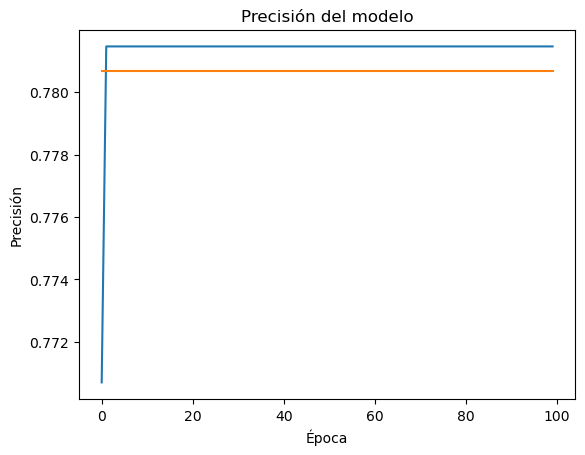

In [487]:
# Gráfica de la precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')

Text(0.5, 0, 'Época')

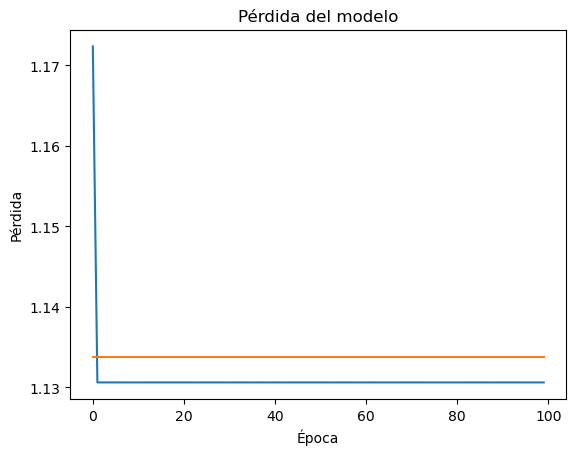

In [488]:
# Gráfica de la pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')

 1/36 [..............................] - ETA: 4s

C:\Users\LAMM_\AppData\Local\Temp\ipykernel_16076\3864170684.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_validate = input_table_validate.drop('label', axis=1).fillna(0)


36/36 [==============================] - 0s 2ms/step


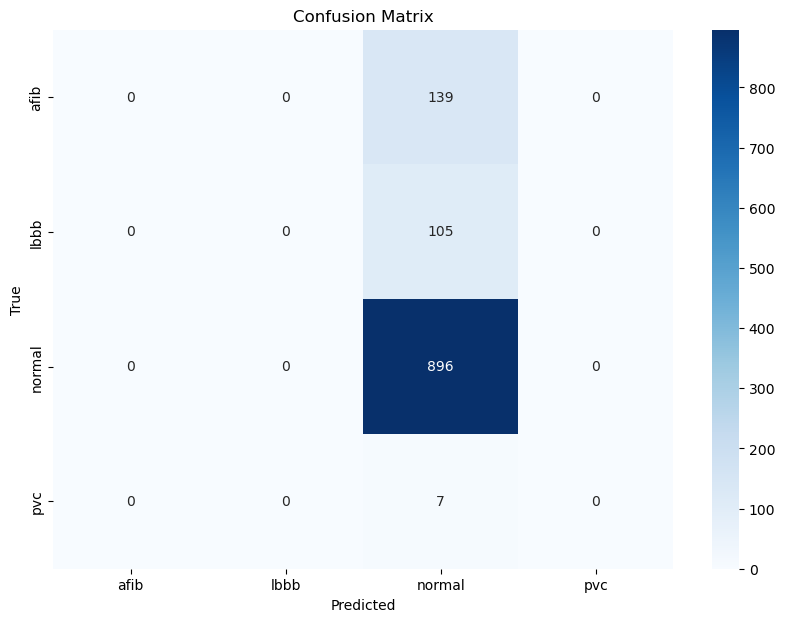

In [489]:
# Matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

X_validate = input_table_validate.drop('label', axis=1).fillna(0)
Y_validate = input_table_validate['label']
Y_validate = pd.get_dummies(Y_validate)

# Make predictions on the validation data
Y_pred = model.predict(X_validate)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_validate.values, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Y_validate.columns, yticklabels=Y_validate.columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [490]:
# Guardar el modelo
model.save('./models/ecg_model.h5')